In [1]:
import torch
from torch import nn
from torch.distributions import Categorical

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class Agent(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Flatten(start_dim=1),
        )
        self.actor = nn.Sequential(
            nn.Linear(7680, 3840),
            nn.LeakyReLU(),
            nn.Linear(3840, 1920),
            nn.LeakyReLU(),
            nn.Linear(1920, 960),
            nn.LeakyReLU(),
            nn.Linear(960, 9),
            nn.Softmax(dim=1),
        )
        self.critic = nn.Sequential(
            nn.Linear(7680, 3840),
            nn.LeakyReLU(),
            nn.Linear(3840, 1920),
            nn.LeakyReLU(),
            nn.Linear(1920, 960),
            nn.LeakyReLU(),
            nn.Linear(960, 1),
        )

    def get_value(self, state):
        features = self.feature_extractor(state)
        return self.critic(features)

    def forward(self, state, action=None):
        features = self.feature_extractor(state)
        
        probabilities = self.actor(features)
        distribution = Categorical(probabilities)
        
        if action == None:
            action = distribution.sample()
        log_prob = distribution.log_prob(action)
        entropy = distribution.entropy()

        value = self.critic(features)
        return action, log_prob, entropy, value
    
    def load(self, model_path="models/a2c_qwop.pth"):
        self.load_state_dict(torch.load(model_path))
        return self

    def save(self, model_path="models/a2c_qwop.pth"):
        torch.save(self.state_dict(), model_path)
        return self


In [3]:
from qwop_env import QWOP_Env
from tqdm import tqdm
from collections import deque
import numpy as np

def state_as_tensor(state):
    state = state.astype(np.float32)
    state = torch.tensor(state).to(device)
    return state

def sim(env: QWOP_Env, agent: Agent, max_steps: int):
    '''
    simulate one episode

    returns: (states, log_probs, rewards, values, entropies)
    '''
    states = []
    actions = []
    log_probs = []
    rewards = []
    values = []
    entropies = []

    state = env.reset()
    for _ in range(4): states.append(state_as_tensor(state))

    with torch.no_grad():
        for step in range(max_steps):
            observation = torch.stack(states[step:step+4]).unsqueeze(0)
            action, log_prob, entropy, value = agent(observation)

            state, reward, done, _ = env.step(action.item())

            states.append(state_as_tensor(state))
            actions.append(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            values.append(value)
            entropies.append(entropy)

            if done:
                break

    return states, actions, log_probs, rewards, values, entropies


In [4]:
def eval(env, agent):
    episode_rewards = []

    with torch.no_grad():
        pbar = tqdm(range(1000))
        for i in pbar:
            _, _, _, rewards, _, _, = sim(env, agent, 1000)
            
            rewards = torch.tensor(rewards).to(device)
            episode_rewards.append(rewards.sum().item())

    return episode_rewards

In [5]:

def train(env: QWOP_Env, agent: Agent, episodes=1000, max_t=1000, gamma=0.9):

    clip_coef = 0.1

    vl_coef = 0.5 # value loss coefficient
    el_coef = 0.01 # entropy loss coefficient

    num_updates = 4

    episode_rewards = []

    optimizer = torch.optim.Adam(agent.parameters(), lr=1e-5)
    value_loss_fn = torch.nn.MSELoss()

    pbar = tqdm(range(episodes))
    for episode in pbar:
        # sim one episode
        states, actions, log_probs, rewards, values, entropies = sim(env, agent, max_t)
        # with torch.no_grad():
        #     observation = torch.stack(states[:-4]).unsqueeze(0)
        #     _, _, _, value = agent(observation.to(device))
        #     values.append(value)
        
        # convert to tensors
        actions = torch.concat(actions)
        rewards = torch.tensor(rewards).unsqueeze(1).to(device)
        episode_rewards.append(rewards.sum().item())
        
        log_probs = torch.concat(log_probs)
        values = torch.concat(values)
        entropies = torch.concat(entropies)

        # calculate advantage
        returns = torch.zeros_like(values)
        for i in range(len(returns)-2, 0, -1):
            returns[i - 1] = gamma * returns[i] + rewards[i - 1]

        advantage = (returns - values)
        advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-10)

        indices = torch.arange(len(states) - 4)
        states = torch.stack(states)

        for update in range(num_updates):
            state_tensor = torch.stack([states[indices], states[indices+1], states[indices+2], states[indices+3]]).moveaxis(0, 1)
            # print(state_tensor.shape, actions[indices].shape)
            _, new_log_probs, entropy, new_value = agent.forward(state_tensor.to(device), actions[indices])
            # print(new_value.shape, new_log_probs.shape, values.shape)
            # print(probabilities.shape)
            # print(log_prob.shape, actions[indices].shape)

            # clip log probs ratio
            log_probs_ratio = new_log_probs - log_probs
            clipped_probs_ratio = torch.clip(log_probs_ratio, 1 - clip_coef, 1 + clip_coef)
            policy_loss = - torch.min(log_probs_ratio * advantage, clipped_probs_ratio * advantage).mean()

            # clip value loss
            clipped_values = values + torch.clip(new_value - values, 1 - clip_coef, 1 + clip_coef)
            # print(values.shape, clipped_values.shape)
            value_loss = torch.max(value_loss_fn(values, rewards), value_loss_fn(clipped_values, rewards)).mean()

            entropy_loss = - entropy.mean()

            loss = policy_loss + value_loss * vl_coef + entropy_loss * el_coef
            # print(loss)
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), 1)
            optimizer.step()

            pbar.set_postfix({
                "reward": rewards.sum().item(),
                "loss": loss.item(), 
                "policy_loss": policy_loss.item(),
                "value_loss": value_loss.item(),
                "entropy_loss": entropy_loss.item(),
            })

        if episode % 10 == 0:
            agent.save()
            agent.save("models/a2c_qwop_backup.pth")
    return episode_rewards


In [6]:
x = torch.tensor([[1,1], [2,2], [3,3], [4,4], [5,5], [6,6], [7,7]])
print(x.shape)
Categorical(logits=x).log_prob(torch.tensor([[0], [1], [0], [1], [0], [1], [0]])).shape

torch.Size([7, 2])


torch.Size([7, 7])

In [7]:
import gym

class CartPoleAgent(Agent):
    def __init__(self):
        super().__init__()
        self.actor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
            nn.Softmax()
        )
        self.critic = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

env = gym.make('CartPole-v0')
agent = CartPoleAgent().to(device)

rewards = train(env, agent, episodes=20000)

import matplotlib.pyplot as plt

plt.plot(rewards)

In [8]:

# rewards = train(env, agent, episodes=20000)

# import matplotlib.pyplot as plt

# plt.plot(rewards)

In [9]:
# rewards = eval(env, agent)

# import matplotlib.pyplot as plt

# plt.plot(rewards)

100%|██████████| 1000/1000 [1:34:11<00:00,  5.65s/it, reward=1, loss=0.787, policy_loss=0.386, value_loss=0.803, entropy_loss=-4.07e-5]    


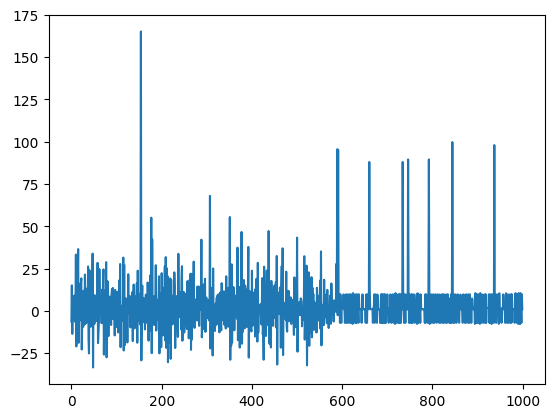

In [12]:
agent = Agent().to(device)
env = QWOP_Env(headless=True).to(device)

rewards = train(env, agent)
import matplotlib.pyplot as plt
plt.plot(rewards)